In [409]:
import pandas as pd, numpy as np
np.set_printoptions(suppress=True)# 关掉科学计数法
import glob
import os
import csv
# 一次性merge多个pct_chg
from functools import reduce
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels import regression

# import tushare as ts
import time, urllib
# ts.set_token('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')
# pro = ts.pro_api('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')

# import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)


# from plotly.graph_objs import Scatter,Layout
# import plotly
# import plotly.offline as py
# import numpy as np
# import plotly.graph_objs as go

# #setting offilne
# plotly.offline.init_notebook_mode(connected=True)

# Functions

- signal_generators: merge market data with technical analysis signals
- position calculators: calculate position based on a variety of principles (money-hedge/beta-hedge/risk-parity)
- ticker filters:
- backtester

# TechnicalIndicators

In [410]:
class TechnicalIndicators(object):

    def EMA(df, n, price_col): # n = 5
        """
        Exponential Moving Average
        rationale CHECKED, code CHECKED, updated.

        params:
            df: pd dataframe
            n: number of days = 5
        """
        EMA = df[price_col].ewm(span=n, min_periods=n - 1).mean().rename('EMA_' + str(n))
        return EMA

    def OBV(df, n, price_col, vol_col): # n = 5
        """On-balance Volume

        On Balance Volume (OBV) measures buying and selling pressure as a cumulative indicator that adds 
        volume on up days and subtracts volume on down days. OBV was developed by Joe Granville and introduced 
        in his 1963 book, Granville's New Key to Stock Market Profits. It was one of the first indicators to 
        measure positive and negative volume flow. Chartists can look for divergences between OBV and price 
        to predict price movements or use OBV to confirm price trends.

        http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:on_balance_volume_obv
        """
        df = df.reset_index()
        i = 0
        OBV = [0]
        while i < df.index[-1]:
            if df.at[i + 1, price_col] - df.at[i, price_col] > 0:
                OBV.append(df.at[i + 1, vol_col])
            if df.at[i + 1, price_col] - df.at[i, price_col] == 0:
                OBV.append(0)
            if df.at[i + 1, price_col] - df.at[i, price_col] < 0:
                OBV.append(-df.at[i + 1, vol_col])
            i = i + 1
        OBV = pd.Series(OBV)
        OBV_ma = pd.Series(OBV.rolling(window=n).mean(), name = 'OBV_' + str(n))
        return OBV_ma

    # Rationale checked
    def MFI(df, n, hi_col, lo_col, price_col, vol_col): # n = 14
        """Money Flow Index and Ratio, updated.
        http://stockcharts.com/docs/doku.php?id=scans:indicators#money_flow_index_mfi

        """
        df = df.reset_index()
        PP = (df[hi_col] + df[lo_col] + df[price_col]) / 3
        i  = 0
        PosMF = [0]
        while i < df.index[-1]:
            if PP[i + 1] > PP[i]:
                PosMF.append(PP[i + 1] * df.at[i + 1, vol_col])
            else:
                PosMF.append(0)
            i = i + 1
        PosMF = pd.Series(PosMF)
        TotMF = PP * df[vol_col]
        MFR   = pd.Series(PosMF / TotMF)
        MFI   = pd.Series(MFR.rolling(window = n, center = False).mean(), name = 'MFI_' + str(n))
        df    = df.join(MFI).set_index("index")
        return df["MFI_" + str(n)]

    # Done
    # Rationale checked
    def RSI(df, n, hi_col, lo_col): # n = 14
        """
        Relative Strength Index, updated.
        Conventional parameters: n = 14, 0.3 and 0.7 are two conventional thresholds
        """
        df = df.reset_index()
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.at[i + 1, hi_col] - df.at[i, hi_col]
            DoMove = df.at[i, lo_col] - df.at[i + 1, lo_col]
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else: UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else: DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI   = pd.Series(UpI)
        DoI   = pd.Series(DoI)
        PosDI = UpI.ewm(span = n, min_periods = n - 1).mean()
        NegDI = DoI.ewm(span = n, min_periods = n - 1).mean()
        RSI   = pd.Series(PosDI / (PosDI + NegDI), name = 'RSI_' + str(n))
        df    = df.join(RSI).set_index("index")
        return df["RSI_" + str(n)]

    def BIAS(df, n, price_col):
        BIAS = df[price_col]-df[price_col].rolling(window=n).mean().rename('BIAS_'+str(n))
        return BIAS

    def MACD(df, n_fast, n_slow, n_macd, price_col): # n_fast = 12, n_slow = 26
        """
        http://stockcharts.com/docs/doku.php?id=scans:indicators
        MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
        # Conventional look-back window for calculating MACDsign is 9
        """
        EMAfast = df[price_col].ewm(span = n_fast, min_periods = n_fast - 1).mean()
        EMAslow = df[price_col].ewm(span = n_slow, min_periods = n_slow - 1).mean()
        MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
        MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
        MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
        df['MACD_Diff'] = MACD
        df['MACD_Diff_EMA'] = MACDsign
        df['MACD'] = MACDdiff
        df['SIGNAL_STATUS'] = df['MACD'].apply(lambda x: "多头状态" if x>0 else ("空头状态" if x<0 else "无信号状态"))
        return df

# TimeSeriesToolbox

In [411]:
class GetData(object):
    
    def get_date_price_code_df(path, ticker_list, date_col, price_col, code_col):
        # for etf data cols are 'date', 'close', 'code'
        ticker_df_list = []
#         print(ticker_list)
        for ticker in ticker_list:
            print(ticker)
            try:
#                 print("get thru")
                
                ticker_df = pd.read_csv(path+ticker+".csv")
                ticker_df[code_col] = ticker_df[code_col].astype(str)
                ticker_df = ticker_df.sort_values(date_col)
                ticker_df = ticker_df[[date_col, price_col, code_col]]
#                 print(ticker_df)
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        try:
            tickers_data_concated = pd.concat(ticker_df_list)
            tickers_data_concated.reset_index(inplace=True)
            del tickers_data_concated['index']  
        except Exception as e:
            print(e)
#         print(tickers_data_concated)
        return tickers_data_concated

In [412]:
class TimeSeriesToolbox(object):
        
    def make_numeric_signals(series):
        for item in series:
            if item =="多":
                return 1
            elif item =="空":
                return -1
            else:
                return 0 
            
    def merge_weights_and_signal(df_actions,
                                 df_wts,
                                 path,
                                 code_col,
                                 date_col,
                                 price_col,
                                 tgt_wts_mutiplier,
                                 account_value):
        if df_actions.empty:
            print("There's no data in df_actions. No actional signals for today!")
            pass
            
        else:
            # 合并仓位数据和信号数据
            df_actions_with_weights = df_wts.merge(df_actions, on =code_col)

            # 仓位太小，创建2倍仓位信息, e.g. tgt_wts_mutiplier = 2
            df_actions_with_weights['weight_enlarged'] = df_actions_with_weights['weight']*tgt_wts_mutiplier
    #         print(df_actions_with_weights)
            # 提取下一日要操作的tickers
            tickers = list(df_actions_with_weights[code_col])
    #         print(tickers)
            # 得到这些tickers的收盘价数据
    #         print(tickers)
            tickers_closes = GetData.get_date_price_code_df(path,
                                                             tickers,
                                                             date_col, 
                                                             price_col, 
                                                             code_col)
    #         print(tickers_closes)
            # 创建今日date信息
            last_date = tickers_closes[date_col].values[-1]
    #         print(last_date)
            # 提取最近一天的tickers的收盘价数据
            tickers_closes_last_date = tickers_closes[tickers_closes[date_col] == last_date]

            # 创建最终的信号-仓位指示信息
            df_actions_with_weights = df_actions_with_weights.merge(tickers_closes_last_date, on = [date_col,
                                                                                                    code_col])
            df_actions_with_weights['tgt_shares'] = account_value*\
                                                    df_actions_with_weights['weight_enlarged']/\
                                                    df_actions_with_weights[price_col]
            return df_actions_with_weights
     
    def merge_current_pos_with_target_pos(path, cur_positions, tgt_last_macd_signals):
        tgt_last_macd_signals['TYPE'] = "TARGET"
        # the following variables should be assigned first
        cur_pos_macd = MACDSignals(path, 
                        cur_positions, 
                        date_col, 
                        code_col, 
                        price_col, 
                        n_fast, 
                        n_slow, 
                        n_macd, 
                        ticker_type)
        cur_pos_macd_signals, \
        cur_pos_last_macd_signals, \
        cur_pos_df_actions = cur_pos_macd.calc_macd_signals()
        cur_pos_last_macd_signals['TYPE'] = 'CUR_POS'
        tgt_cur_macd_signal_df = cur_pos_last_macd_signals.merge(tgt_last_macd_signals, on = [date_col,code_col], how = 'outer')
        return tgt_cur_macd_signal_df

# PlotToolbox

In [413]:
class PlotToolbox(object):
    
    def pie_graph(values, labels, pie_length, pie_width, title_name):
        # draw pie graph
        plt.figure(1, figsize = (pie_length, pie_width))
        plt.axes(aspect=1)
        plt.pie(x=values, labels=labels, autopct='%3.1f %%')
        plt.title(title_name, fontsize = 15)
        plt.show()
        
        
    def plot_macd_signals(ticker, macd_signals, tail_num):
        ticker_macd_signals = macd_signals[macd_signals[code_col]==ticker]
        ticker_macd_signals.set_index(date_col, inplace = True)
        ticker_macd_signals[[code_col,"MACD"]].tail(tail_num).plot(figsize = (15,6))

In [414]:
# 在分析环境里，筛选出tickers，然后使用MACD_signals

class MACDSignals(object):
    
    def __init__(self, stocks_path, tickers, date_col, code_col, price_col, n_fast, n_slow, n_macd, ticker_type):
        self.path = stocks_path
        self.tickers = tickers
        self.date_col = date_col
        self.code_col = code_col
        self.price_col = price_col
        self.n_fast = n_fast
        self.n_slow = n_slow
        self.n_macd = n_macd
        self.ticker_type = ticker_type
        self.mkt_data = self.get_mkt_data_df()

    def get_mkt_data_df(self):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
        csv_path = self.path+"*.csv"
        files = glob.glob(csv_path)
        ticker_df_list = []
        for ticker in tickers:
            try:
                ticker_df = pd.read_csv(self.path+ticker+".csv")
                ticker_df[self.code_col] = ticker_df[self.code_col].astype(str)
                ticker_df = ticker_df.sort_values(self.date_col)
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        try:
            tickers_data_concated = pd.concat(ticker_df_list)
            tickers_data_concated.reset_index(inplace=True)
            del tickers_data_concated['index']  
        except Exception as e:
            print(e)
        return tickers_data_concated
    

    def calc_macd_signals(self):
        tickers_data_concated = self.mkt_data
#         print(tickers_data_concated)
        signal_record = []
        signal_data = []
        if len(self.tickers)!=1:
            for ticker in self.tickers:
                try:
                    if self.ticker_type == "float":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==float(ticker)]
                    elif self.ticker_type == "string":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==ticker]
                        
                    signal_df = TechnicalIndicators.MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)
                    
                    signal_data.append(signal_df)
                except:
                    pass
            signal_data_df = pd.concat(signal_data)
        else:
            try:                
                signal_df = TechnicalIndicators.MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)
            except:
                pass
            signal_data_df = signal_df

        # v1 is the version of generating the og macd signals
        signal_data_df['SIGNAL_DIRECTION'] = signal_data_df['SIGNAL_STATUS'].apply(lambda x: TimeSeriesToolbox.make_numeric_signals(x))
        signal_data_df['SIGNAL_DIRECTION_DIFF'] = signal_data_df.groupby([self.code_col])['SIGNAL_DIRECTION'].diff()
        signal_data_df['SIGNAL_ACTION'] = signal_data_df['SIGNAL_DIRECTION_DIFF'].apply(lambda x: "LONG" if x==2 else("SHORT" if x==-2 else "NO CHANGE"))
#         print(signal_data_df)
        most_recent_signals = signal_data_df.groupby([self.code_col])[[self.date_col,self.code_col,'SIGNAL_STATUS','SIGNAL_ACTION']].tail(1)
        df_actions = most_recent_signals[most_recent_signals["SIGNAL_ACTION"]!="NO CHANGE"]
        return signal_data_df, most_recent_signals, df_actions

In [415]:
from scipy.optimize import minimize

class RiskParity(object):
    
    def __init__(self, stocks_path, tickers, 
                 date_col, code_col, price_col, 
                 ticker_type, asset_name, draw_pie_graph):
        
        self.path = stocks_path
        self.tickers = tickers
        self.date_col = date_col
        self.code_col = code_col
        self.price_col = price_col
        self.ticker_type = ticker_type
        self.asset_name = asset_name
        self.draw_pie_graph = draw_pie_graph
        self.ticker_df_list = self.get_date_price_code_return_list()
        self.tgt_returns = self.ticker_df_list
        self.tgt_merged_returns = self.merge_dfs_by_ticker(self.tgt_returns, 
                                                           self.date_col)
        self.wts, self.risk = self.get_smart_weight(self.tgt_merged_returns, 
                                                    method='risk parity', 
                                                    cov_adjusted=False, 
                                                    wts_adjusted=False)
        self.df_wts, self.risk_parity_tickers, self.weights = self.get_df_wts()
        
        
    # Get date_col, price_col, code_col, pct_chg_col
    def get_date_price_code_return_list(self):
        # for etf data cols are 'date', 'close', 'code'
        ticker_df_list = []
        for ticker in self.tickers:
            try:
                ticker_df = pd.read_csv(self.path+ticker+".csv")
                ticker_df = ticker_df.sort_values(self.date_col)
                ticker_df = ticker_df[[self.date_col, 
                                       self.price_col, 
                                       self.code_col]]
                ticker_df['pct_chg'] = ticker_df[self.price_col].pct_change()
                ticker_df = ticker_df[[self.date_col, 'pct_chg']].dropna()
                ticker_df.columns = [self.date_col, ticker]
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        return ticker_df_list
    
    
    def merge_dfs_by_ticker(self, ticker_df_list, date_col):
        merged_all = reduce(lambda left, right: pd.merge(left, right, on=date_col), ticker_df_list)
#         merged_all = reduce(merge_df_for_reduce, ticker_df_list)
        merged_all.set_index(self.date_col, inplace=True)
        merged_all.dropna(how="all", axis = 1, inplace = True)
        merged_all.fillna(method="ffill", inplace = True)
        return merged_all
        
        
    def get_smart_weight(self, pct, method='risk parity', cov_adjusted=False, wts_adjusted=False):
        if cov_adjusted == False:
            #协方差矩阵
            cov_mat = pct.cov()
        else:
            #调整后的半衰协方差矩阵
            cov_mat = pct.iloc[:len(pct)/4].cov()*(1/10.) + pct.iloc[len(pct)/4+1:len(pct)/2].cov()*(2/10.) +\
                pct.iloc[len(pct)/2+1:len(pct)/4*3].cov()*(3/10.) + pct.iloc[len(pct)/4*3+1:].cov()*(4/10.)
        if not isinstance(cov_mat, pd.DataFrame):
            raise ValueError('cov_mat should be pandas DataFrame！')

        omega = np.matrix(cov_mat.values)  # 协方差矩阵

        a, b = np.linalg.eig(np.array(cov_mat)) #a为特征值,b为特征向量
        a = np.matrix(a)
        b = np.matrix(b)
        # 定义目标函数
    
        def fun1(x):
            tmp = (omega * np.matrix(x).T).A1
            risk = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
            delta_risk = [sum((i - risk)**2) for i in risk]
            return sum(delta_risk)

        def fun2(x):
            tmp = (b**(-1) * omega * np.matrix(x).T).A1
            risk = (b**(-1)*np.matrix(x).T).A1 * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
            delta_risk = [sum((i - risk)**2) for i in risk]
            return sum(delta_risk)
    
        # 初始值 + 约束条件 
        x0 = np.ones(omega.shape[0]) / omega.shape[0]  
        bnds = tuple((0,None) for x in x0)
        cons = ({'type':'eq', 'fun': lambda x: sum(x) - 1})
        options={'disp':False, 'maxiter':1000, 'ftol':1e-20}

        if method == 'risk parity':
            res = minimize(fun1, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
        elif method == 'pc risk parity':
            res = minimize(fun2, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
        else:
            raise ValueError('method error！！！')

        # 权重调整
        if res['success'] == False:
            # print res['message']
            pass
        wts = pd.Series(index=cov_mat.index, data=res['x'])

        if wts_adjusted == True:
            wts[wts < 0.0001]=0.0
            wts = wts / wts.sum()
        elif wts_adjusted == False:
            wts = wts / wts.sum()
        else:
            raise ValueError('wts_adjusted should be True/False！')

        risk = pd.Series(wts * (omega * np.matrix(wts).T).A1 / np.sqrt(np.matrix(wts) * omega * np.matrix(wts).T).A1[0],index = cov_mat.index)
        risk[risk<0.0] = 0.0
        return wts,risk
    
        
    def get_df_wts(self):
        df_wts = pd.DataFrame(self.wts)
        df_wts.reset_index(inplace = True)
        df_wts.columns = [self.asset_name, 'weight']
        risk_parity_tickers = list(df_wts[self.asset_name])
        weights = list(df_wts['weight'])
        return df_wts, risk_parity_tickers, weights


In [416]:
# Mannually check our current position holdings for potential exit signals:
cur_positions = [
#     "510180",#180ETF
#     "510300",#300ETF
#     "510810",#上海国企
#     "510850",#工银上50
#     "510880",#红利ETF
#     '512000', #券商ETF -
#     '512010',#医药ETF
#     "512400",#有色ETF
    "512660",#军工ETF
    '512690',#酒ETF
#     '512800',#银行ETF
#     '512880',#证券ETF -
#     '159928',#消费ETF
#     '512290',#生物医药ETF -
#     '513050',#中概互联网
#     '513100',#纳指ETF
#     '513500',#标普500
#     '518880',#黄金ETF
#     "159905",#深红利
#     "159920",#恒生ETF
    "159959", #央企ETF -
#     "159939"# 信息技术
#     '159938',#医药 -
#     ''#券商ETF
    '512960',#央调ETF
#     ''#证券ETF
#     ''#标普500
    
]
len(cur_positions)

4

In [417]:
# returns = {
#     "2020-03-02":0,
#     "2020-03-03":0,
#     "2020-03-04":0,
#     "2020-03-05":0,
#     "2020-03-06":0,
#     "2020-03-09":-0.21,
#     "2020-03-10":0.04,
#     "2020-03-11":-0.08,
#     "2020-03-12":-0.21,
#     "2020-03-13":-0.1,
#     "2020-03-16":0,
#     "2020-03-17":0,
#     "2020-03-18":0,
#     "2020-03-19":0,
#     "2020-03-20":0.01,
#     "2020-03-23":0,
#     "2020-03-24":0,
#     "2020-03-25":-0.01,
#     "2020-03-26":-0.02,
#     "2020-03-27":-0.41,
#     "2020-03-30":-0.39,
#     "2020-03-31":0.12,
#     "2020-04-01":-0.61,
#     "2020-04-02":0.82,
#     "2020-04-03":-0.18,
#     "2020-04-07":1.74,
#     "2020-04-08":-0.33,
#     "2020-04-09":0.42,
#     "2020-04-10":

# }
# returns_df = pd.DataFrame(pd.Series(returns), columns=['daily_rtrn'])
# returns_df = returns_df.reset_index().rename(columns = {"index":"date"})
# returns_df['daily_rtrn'] = returns_df['daily_rtrn']/100
# returns_df['sum_rtrn'] = returns_df['daily_rtrn'].cumsum()
# returns_df['equity_rtrn'] = returns_df['sum_rtrn']+1

In [418]:
print("Mark's total share returns:",2000*(5/9))
print("Brad's total share returns:",2000*(2/9))
print("Kevin's total share returns:",2000*(2/9))

Mark's total share returns: 1111.111111111111
Brad's total share returns: 444.4444444444444
Kevin's total share returns: 444.4444444444444


In [419]:
if __name__=="__main__":
    stocks_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    etfs_df = pd.read_csv("filtered_50_etfs_by_vol_20200224.csv")
    tickers = list(etfs_df['etf'].str.split(".",expand = True)[0])
#     date_col = 'trade_date'
#     code_col = 'ts_code'
#     price_col = 'close'
    date_col = 'date'
    code_col = 'code'
    price_col = 'close'
    ticker_type = 'string'
    asset_name = "code"
    tgt_wts_mutiplier = 4
    account_value = 100000
    
#     # ========For calculating MACD signals========
    n_fast = 12
    n_slow = 26
    n_macd = 9
    macd = MACDSignals(stocks_path, 
                        tickers, 
                        date_col, 
                        code_col, 
                        price_col, 
                        n_fast, 
                        n_slow, 
                        n_macd, 
                        ticker_type)
    macd_signals, last_macd_signals, df_actions = macd.calc_macd_signals()

    # ========For calculating risk-parity weights========
    risk_parity = RiskParity(stocks_path,
                              tickers,
                              date_col,
                              code_col,
                              price_col,
                              ticker_type,
                              asset_name,
                              True)
    
    df_wts, risk_parity_tickers, weights = risk_parity.get_df_wts()
    
    df_actions_with_weights = TimeSeriesToolbox.merge_weights_and_signal(df_actions,
                                                                     df_wts,
                                                                     stocks_path,
                                                                     code_col,
                                                                     date_col,
                                                                     price_col,
                                                                     tgt_wts_mutiplier,
                                                                     account_value)
#     PlotToolbox.pie_graph(weights, risk_parity_tickers, 8, 8, "Risk Parity Allocation")

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

159920


In [420]:
8211*1.5

12316.5

In [421]:
tgt_cur_pos_df = TimeSeriesToolbox.merge_current_pos_with_target_pos(stocks_path, cur_positions, last_macd_signals)

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

# Reentry

In [422]:
def find_recent_goldcross_close(close, signal_diff):
    if signal_diff == 1 or signal_diff == 2:
        return close

macd_signals['recent_goldcross'] = macd_signals.apply(lambda row: find_recent_goldcross_close(row['close'],row['SIGNAL_DIRECTION_DIFF']), axis=1)

# forward-fill all NaNs for the recent_goldcross to pave way for calculating the pct_diff between current 
# close and the rencent goldcross close
macd_signals['recent_goldcross_ffill'] = macd_signals.groupby("code")['recent_goldcross'].apply(lambda x: x.fillna(method="ffill"))
macd_signals['pctchg_from_recent_goldcrossclose'] = (macd_signals['close']-macd_signals['recent_goldcross_ffill'])/macd_signals['recent_goldcross_ffill']
macd_signals['reentry_rank'] = macd_signals.groupby(["date"])['pctchg_from_recent_goldcrossclose'].rank(ascending = True)
last_day = macd_signals['date'].values[-1]
macd_signals_reentry = macd_signals[macd_signals['date']==last_day][macd_signals['pctchg_from_recent_goldcrossclose']<0]

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


In [423]:
all_reentry_tickers = list(macd_signals_reentry['code'])
tickers_to_reenter = []
for ticker in all_reentry_tickers:
    if ticker not in cur_positions:
        tickers_to_reenter.append(ticker)

In [424]:
tickers_to_reenter_df = pd.DataFrame(tickers_to_reenter, columns=['code'])
df_actions_with_weights_reentry = df_wts.merge(tickers_to_reenter_df, on = ['code'])
macd_signals_reentry = macd_signals[macd_signals['date']==last_day]
df_actions_with_weights_reentry = df_actions_with_weights_reentry.merge(macd_signals_reentry, on = 'code')
df_actions_with_weights_reentry['weight_enlarged'] = df_actions_with_weights_reentry['weight']*tgt_wts_mutiplier

In [425]:
df_actions_with_weights_reentry['tgt_shares'] = account_value*\
                                                    df_actions_with_weights_reentry['weight_enlarged']/\
                                                    df_actions_with_weights_reentry[price_col]

df_actions_with_weights_reentry = df_actions_with_weights_reentry[['code','date','SIGNAL_STATUS','SIGNAL_ACTION',\
                                                                   'weight_enlarged','close','tgt_shares',\
                                                                   'pctchg_from_recent_goldcrossclose','reentry_rank']]
df_actions_with_weights_reentry.sort_values('reentry_rank', ascending=True, inplace=True)
df_actions_with_weights_reentry_L = df_actions_with_weights_reentry[df_actions_with_weights_reentry['SIGNAL_STATUS']=="多头状态"]

In [426]:
df_actions_with_weights_reentry_L

,code,date,SIGNAL_STATUS,SIGNAL_ACTION,weight_enlarged,close,tgt_shares,pctchg_from_recent_goldcrossclose,reentry_rank
0,518880,2020-07-02,多头状态,NO CHANGE,4.140861e-24,3.903,1.060943e-19,-0.00179,1.0


In [427]:
selected_reentry_tickers = list(df_actions_with_weights_reentry_L['code'])

In [428]:
selected_reentry_tickers

['518880']

# Check Current Positions

In [429]:
# Show if there are any actions needed to be made for our current positions
tgt_cur_pos_df[tgt_cur_pos_df['TYPE_x']=="CUR_POS"]

,date,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y
0,2020-07-02,512660,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET
1,2020-07-02,512690,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET
2,2020-07-02,159959,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET
3,2020-07-02,512960,多头状态,NO CHANGE,CUR_POS,多头状态,NO CHANGE,TARGET


In [430]:
9228.5-369.4

8859.1

# Check if there's new positions to be entered

In [431]:
# Check if there are any new positions to be entered
tgt_cur_pos_df[(tgt_cur_pos_df['TYPE_x']!="CUR_POS")&(tgt_cur_pos_df['SIGNAL_ACTION_y']!="NO CHANGE")]

,date,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y
7,2020-07-02,159920,NaN,NaN,NaN,多头状态,LONG,TARGET


In [432]:
try:
    df_actions_with_weights = df_actions_with_weights[df_actions_with_weights['SIGNAL_ACTION']=='LONG']
except:
    pass

In [433]:
try:
    df_actions_tickers = list(df_actions_with_weights['code'])
except:
    pass

In [434]:
symbol_list_to_backtest = df_actions_tickers+selected_reentry_tickers
symbol_list_to_backtest

['159920', '518880']

In [435]:
set(symbol_list_to_backtest)

{'159920', '518880'}

In [436]:
df_actions_with_weights

,code,weight,date,SIGNAL_STATUS,SIGNAL_ACTION,weight_enlarged,close,tgt_shares
0,159920,0.027731,2020-07-02,多头状态,LONG,0.110923,1.41,7866.855239


In [437]:
1500*3.910

5865.0

# Backtest and filter

In [438]:
from CH_backtest import *

In [439]:
ticker_performances = {}

if __name__ == "__main__":
    for ticker in symbol_list_to_backtest:
    # csv_dir = REPLACE_WITH_YOUR_CSV_DIR_HERE
        equity_folder = "./"
        csv_dir = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
#         data_cols = ['trade_date', 'open', 'high','low', 'close', 'volume','ts_code'] #for ETFs # 要改代码
#         data_cols = ['ts_code','trade_date','open','high','low','close','pre_close','change','pct_chg','vol','amount'] #for stocks
#         commissions = 5 # RMB/USD per trade #要改代码
        initial_capital = 1000000.0
        start_date = datetime.datetime(1991,12,1,0,0,0)
        start_date_str = str(start_date)
        heartbeat = 0.0
#         price_col = "close" #要改代码
#         qty = 5000 # 要改代码
        backtest = Backtest(csv_dir, 
                            [ticker], 
                            initial_capital, 
                            heartbeat,
                            start_date,
                            HistoricCSVDataHandler, 
                            SimulatedExecutionHandler, 
                            Portfolio, 
    #                         MovingAverageCrossStrategy,
                           MovingAverageConvergenceDivergence)

        backtest.simulate_trading()
        df_equity = pd.read_csv(ticker+"_performance"+".csv")
        df_equity.drop_duplicates("datetime", inplace = True)
        df_equity =df_equity[df_equity['datetime']>start_date_str]
        df_equity.index = df_equity['datetime']
        df_equity = df_equity[df_equity['total'].map(lambda x: str(x)!="nan")]
        df_equity.columns = ['datetime', 'market_value', 'cash', 'commission', 'total', 'returns',
        'equity_curve', 'drawdown']
        df_equity_copy = df_equity.copy()
        data = df_equity_copy
#         win_rate, mean_win_loss_ratio, bt_score, profits = performance(data)
        single_stats = performance(data)
#         print("TICKER: ", ticker)
        ticker_performances[ticker] = single_stats

Number of assets in the portfolio：  1
Position Value for each asset:  1000000.0
Asset:  159920 symbol_value:  0.988 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.981 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.993 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.007 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.022 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.042 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.035 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.987 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.996 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.993 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.99 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.005 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.94 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.977 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.002 mkt_quantity:  5000
Asset:  159920 symbol_value:  0.976 mkt_quantity:  5000
Asset:  159920 symbol_valu

Asset:  159920 symbol_value:  1.46 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.524 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.547 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.536 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.4480000000000002 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.472 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.47 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.476 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.489 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.456 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.459 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.5330000000000001 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.528 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.474 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.301 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.318 mkt_quantity:  5000
Asset:  159920 symbol_value:  1.374 mkt_quantity:  5000
Asset:  159920 symbol_va

Holding the position:  2013-09-25
Holding the position:  2013-09-26
Holding the position:  2013-09-27
Holding the position:  2013-09-30
Closed the position:  2013-10-08
This trade's pnl: 155.0
-------------------
Position is empty:  2013-10-08
Position is empty:  2013-10-09
Position is empty:  2013-10-10
Position is empty:  2013-10-11
Position is empty:  2013-10-14
Position is empty:  2013-10-15
Position is empty:  2013-10-16
Position is empty:  2013-10-17
Position is empty:  2013-10-18
Position is empty:  2013-10-21
-------------------
Opened the position:  2013-10-22
Holding the position:  2013-10-23
Closed the position:  2013-10-24
This trade's pnl: -75.0
-------------------
Position is empty:  2013-10-24
Position is empty:  2013-10-25
Position is empty:  2013-10-28
Position is empty:  2013-10-29
Position is empty:  2013-10-30
Position is empty:  2013-10-31
-------------------
Opened the position:  2013-11-01
Holding the position:  2013-11-04
Holding the position:  2013-11-05
Holdin

Closed the position:  2014-09-12
This trade's pnl: -145.0
-------------------
Position is empty:  2014-09-12
Position is empty:  2014-09-15
Position is empty:  2014-09-16
Position is empty:  2014-09-17
Position is empty:  2014-09-18
Position is empty:  2014-09-19
Position is empty:  2014-09-22
Position is empty:  2014-09-23
Position is empty:  2014-09-24
Position is empty:  2014-09-25
Position is empty:  2014-09-26
Position is empty:  2014-09-29
Position is empty:  2014-09-30
Position is empty:  2014-10-08
Position is empty:  2014-10-09
Position is empty:  2014-10-10
Position is empty:  2014-10-13
Position is empty:  2014-10-14
Position is empty:  2014-10-15
Position is empty:  2014-10-16
Position is empty:  2014-10-17
Position is empty:  2014-10-20
Position is empty:  2014-10-21
Position is empty:  2014-10-22
Position is empty:  2014-10-23
-------------------
Opened the position:  2014-10-24
Holding the position:  2014-10-27
Holding the position:  2014-10-28
Holding the position:  201

Position is empty:  2015-08-24
Position is empty:  2015-08-25
Position is empty:  2015-08-26
Position is empty:  2015-08-27
Position is empty:  2015-08-28
Position is empty:  2015-08-31
Position is empty:  2015-09-01
Position is empty:  2015-09-02
Position is empty:  2015-09-07
Position is empty:  2015-09-08
Position is empty:  2015-09-09
Position is empty:  2015-09-10
Position is empty:  2015-09-11
-------------------
Opened the position:  2015-09-14
Holding the position:  2015-09-15
Holding the position:  2015-09-16
Holding the position:  2015-09-17
Holding the position:  2015-09-18
Holding the position:  2015-09-21
Holding the position:  2015-09-22
Holding the position:  2015-09-23
Holding the position:  2015-09-24
Holding the position:  2015-09-25
Holding the position:  2015-09-28
Holding the position:  2015-09-29
Closed the position:  2015-09-30
This trade's pnl: -235.0
-------------------
Position is empty:  2015-09-30
Position is empty:  2015-10-08
Position is empty:  2015-10-09

Holding the position:  2016-08-30
Holding the position:  2016-08-31
Holding the position:  2016-09-01
Holding the position:  2016-09-02
Holding the position:  2016-09-05
Holding the position:  2016-09-06
Holding the position:  2016-09-07
Holding the position:  2016-09-08
Holding the position:  2016-09-09
Holding the position:  2016-09-12
Holding the position:  2016-09-13
Holding the position:  2016-09-14
Holding the position:  2016-09-19
Holding the position:  2016-09-20
Holding the position:  2016-09-21
Holding the position:  2016-09-22
Holding the position:  2016-09-23
Holding the position:  2016-09-26
Closed the position:  2016-09-27
This trade's pnl: 335.0
-------------------
Position is empty:  2016-09-27
Position is empty:  2016-09-28
Position is empty:  2016-09-29
Position is empty:  2016-09-30
Position is empty:  2016-10-10
Position is empty:  2016-10-11
Position is empty:  2016-10-12
Position is empty:  2016-10-13
Position is empty:  2016-10-14
Position is empty:  2016-10-17
P

Holding the position:  2017-10-23
Holding the position:  2017-10-24
Holding the position:  2017-10-25
Closed the position:  2017-10-26
This trade's pnl: 195.0
-------------------
Position is empty:  2017-10-26
Position is empty:  2017-10-27
Position is empty:  2017-10-30
Position is empty:  2017-10-31
Position is empty:  2017-11-01
Position is empty:  2017-11-02
Position is empty:  2017-11-03
Position is empty:  2017-11-06
Position is empty:  2017-11-07
Position is empty:  2017-11-08
-------------------
Opened the position:  2017-11-09
Holding the position:  2017-11-10
Holding the position:  2017-11-13
Holding the position:  2017-11-14
Holding the position:  2017-11-15
Holding the position:  2017-11-16
Holding the position:  2017-11-17
Holding the position:  2017-11-20
Holding the position:  2017-11-21
Holding the position:  2017-11-22
Holding the position:  2017-11-23
Holding the position:  2017-11-24
Holding the position:  2017-11-27
Holding the position:  2017-11-28
Holding the posi

Position is empty:  2018-09-19
Position is empty:  2018-09-20
-------------------
Opened the position:  2018-09-21
Holding the position:  2018-09-25
Holding the position:  2018-09-26
Holding the position:  2018-09-27
Holding the position:  2018-09-28
Holding the position:  2018-10-08
Holding the position:  2018-10-09
Closed the position:  2018-10-10
This trade's pnl: -255.0
-------------------
Position is empty:  2018-10-10
Position is empty:  2018-10-11
Position is empty:  2018-10-12
Position is empty:  2018-10-15
Position is empty:  2018-10-16
Position is empty:  2018-10-17
Position is empty:  2018-10-18
Position is empty:  2018-10-19
Position is empty:  2018-10-22
Position is empty:  2018-10-23
Position is empty:  2018-10-24
Position is empty:  2018-10-25
Position is empty:  2018-10-26
Position is empty:  2018-10-29
Position is empty:  2018-10-30
Position is empty:  2018-10-31
Position is empty:  2018-11-01
-------------------
Opened the position:  2018-11-02
Holding the position:  

Holding the position:  2019-11-01
Holding the position:  2019-11-04
Holding the position:  2019-11-05
Holding the position:  2019-11-06
Holding the position:  2019-11-07
Holding the position:  2019-11-08
Holding the position:  2019-11-11
Holding the position:  2019-11-12
Closed the position:  2019-11-13
This trade's pnl: 20.0
-------------------
Position is empty:  2019-11-13
Position is empty:  2019-11-14
Position is empty:  2019-11-15
Position is empty:  2019-11-18
Position is empty:  2019-11-19
Position is empty:  2019-11-20
Position is empty:  2019-11-21
Position is empty:  2019-11-22
Position is empty:  2019-11-25
Position is empty:  2019-11-26
-------------------
Opened the position:  2019-11-27
Holding the position:  2019-11-28
Holding the position:  2019-11-29
Closed the position:  2019-12-02
This trade's pnl: -175.0
-------------------
Position is empty:  2019-12-02
Position is empty:  2019-12-03
Position is empty:  2019-12-04
Position is empty:  2019-12-05
Position is empty: 

Asset:  518880 symbol_value:  2.395 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.416 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.511 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.376 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.364 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.394 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.384 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.391 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.369 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.403 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.381 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.406 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.3890000000000002 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.188 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.32 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.329 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.384 mkt_quantity:  5000
Asset:  518880 symbol_value:  2.21 m

Position is empty:  2013-11-26
Position is empty:  2013-11-27
Position is empty:  2013-11-28
Position is empty:  2013-11-29
Position is empty:  2013-12-02
Position is empty:  2013-12-03
Position is empty:  2013-12-04
Position is empty:  2013-12-05
Position is empty:  2013-12-06
Position is empty:  2013-12-09
Position is empty:  2013-12-10
-------------------
Opened the position:  2013-12-11
Holding the position:  2013-12-12
Holding the position:  2013-12-13
Holding the position:  2013-12-16
Holding the position:  2013-12-17
Holding the position:  2013-12-18
Holding the position:  2013-12-19
Closed the position:  2013-12-20
This trade's pnl: -165.0
-------------------
Position is empty:  2013-12-20
Position is empty:  2013-12-23
Position is empty:  2013-12-24
Position is empty:  2013-12-25
Position is empty:  2013-12-26
Position is empty:  2013-12-27
Position is empty:  2013-12-30
Position is empty:  2013-12-31
Position is empty:  2014-01-02
Position is empty:  2014-01-03
--------------

Holding the position:  2015-01-09
Holding the position:  2015-01-12
Holding the position:  2015-01-13
Holding the position:  2015-01-14
Holding the position:  2015-01-15
Holding the position:  2015-01-16
Holding the position:  2015-01-19
Holding the position:  2015-01-20
Holding the position:  2015-01-21
Holding the position:  2015-01-22
Holding the position:  2015-01-23
Holding the position:  2015-01-26
Holding the position:  2015-01-27
Holding the position:  2015-01-28
Holding the position:  2015-01-29
Holding the position:  2015-01-30
Closed the position:  2015-02-02
This trade's pnl: 465.0
-------------------
Position is empty:  2015-02-02
Position is empty:  2015-02-03
Position is empty:  2015-02-04
Position is empty:  2015-02-05
Position is empty:  2015-02-06
Position is empty:  2015-02-09
Position is empty:  2015-02-10
Position is empty:  2015-02-11
Position is empty:  2015-02-12
Position is empty:  2015-02-13
Position is empty:  2015-02-16
Position is empty:  2015-02-17
Positio

Position is empty:  2016-03-23
Position is empty:  2016-03-24
Position is empty:  2016-03-25
Position is empty:  2016-03-28
Position is empty:  2016-03-29
Position is empty:  2016-03-30
Position is empty:  2016-03-31
Position is empty:  2016-04-01
Position is empty:  2016-04-05
Position is empty:  2016-04-06
Position is empty:  2016-04-07
Position is empty:  2016-04-08
-------------------
Opened the position:  2016-04-11
Holding the position:  2016-04-12
Holding the position:  2016-04-13
Holding the position:  2016-04-14
Holding the position:  2016-04-15
Holding the position:  2016-04-18
Holding the position:  2016-04-19
Holding the position:  2016-04-20
Holding the position:  2016-04-21
Holding the position:  2016-04-22
Holding the position:  2016-04-25
Holding the position:  2016-04-26
Holding the position:  2016-04-27
Holding the position:  2016-04-28
Holding the position:  2016-04-29
Holding the position:  2016-05-03
Holding the position:  2016-05-04
Holding the position:  2016-05-

Position is empty:  2017-05-16
Position is empty:  2017-05-17
Position is empty:  2017-05-18
-------------------
Opened the position:  2017-05-19
Holding the position:  2017-05-22
Holding the position:  2017-05-23
Holding the position:  2017-05-24
Holding the position:  2017-05-25
Holding the position:  2017-05-26
Holding the position:  2017-05-31
Holding the position:  2017-06-01
Holding the position:  2017-06-02
Holding the position:  2017-06-05
Holding the position:  2017-06-06
Holding the position:  2017-06-07
Holding the position:  2017-06-08
Holding the position:  2017-06-09
Holding the position:  2017-06-12
Closed the position:  2017-06-13
This trade's pnl: -125.0
-------------------
Position is empty:  2017-06-13
Position is empty:  2017-06-14
Position is empty:  2017-06-15
Position is empty:  2017-06-16
Position is empty:  2017-06-19
Position is empty:  2017-06-20
Position is empty:  2017-06-21
Position is empty:  2017-06-22
Position is empty:  2017-06-23
Position is empty:  2

Position is empty:  2018-07-20
Position is empty:  2018-07-23
Position is empty:  2018-07-24
Position is empty:  2018-07-25
Position is empty:  2018-07-26
Position is empty:  2018-07-27
-------------------
Opened the position:  2018-07-30
Holding the position:  2018-07-31
Holding the position:  2018-08-01
Holding the position:  2018-08-02
Holding the position:  2018-08-03
Holding the position:  2018-08-06
Holding the position:  2018-08-07
Closed the position:  2018-08-08
This trade's pnl: -40.0
-------------------
Position is empty:  2018-08-08
Position is empty:  2018-08-09
Position is empty:  2018-08-10
Position is empty:  2018-08-13
Position is empty:  2018-08-14
Position is empty:  2018-08-15
Position is empty:  2018-08-16
Position is empty:  2018-08-17
Position is empty:  2018-08-20
Position is empty:  2018-08-21
Position is empty:  2018-08-22
Position is empty:  2018-08-23
Position is empty:  2018-08-24
Position is empty:  2018-08-27
Position is empty:  2018-08-28
---------------

Opened the position:  2019-09-26
Holding the position:  2019-09-27
Closed the position:  2019-09-30
This trade's pnl: -375.0
-------------------
Position is empty:  2019-09-30
Position is empty:  2019-10-08
Position is empty:  2019-10-09
-------------------
Opened the position:  2019-10-10
Holding the position:  2019-10-11
Holding the position:  2019-10-14
Closed the position:  2019-10-15
This trade's pnl: -455.0
-------------------
Position is empty:  2019-10-15
Position is empty:  2019-10-16
Position is empty:  2019-10-17
Position is empty:  2019-10-18
Position is empty:  2019-10-21
Position is empty:  2019-10-22
Position is empty:  2019-10-23
Position is empty:  2019-10-24
Position is empty:  2019-10-25
Position is empty:  2019-10-28
-------------------
Opened the position:  2019-10-29
Closed the position:  2019-10-30
This trade's pnl: -170.0
-------------------
Position is empty:  2019-10-30
Position is empty:  2019-10-31
Position is empty:  2019-11-01
Position is empty:  2019-11-0

In [440]:
pd.DataFrame(ticker_performances)

,159920,518880
total_commission,860,785
gross_profit,40,3660
net_profit,-820,2875
commission_impact,2150.0%,21.45%
win %,39.53,38.46
PL Ratio,1.35,2.06
overall_score,-0.07,0.18


# Visualize Signal Status on Long/Shorts

In [441]:
def MACD_long_short_counts(macd_signals, date_col, code_col):
    long_short_counts = macd_signals.groupby([date_col,'SIGNAL_DIRECTION'])[code_col].count()
    long_short_counts_df = pd.DataFrame(long_short_counts)
    long_short_counts_df.reset_index(inplace=True)
    long_counts_df = long_short_counts_df[long_short_counts_df['SIGNAL_DIRECTION']==1]
    short_counts_df = long_short_counts_df[long_short_counts_df['SIGNAL_DIRECTION']==-1]
    long_short_counts_df_merged = long_counts_df.merge(short_counts_df, on = date_col)
    long_short_counts_df_merged['long_short_ratio'] = long_short_counts_df_merged['code_x']/(\
                                                                            long_short_counts_df_merged['code_x']+\
                                                                            long_short_counts_df_merged['code_y'])
    long_short_counts_df_merged.index = pd.to_datetime(long_short_counts_df_merged[date_col])
    return long_short_counts_df_merged

In [442]:
macd_long_short_counts = MACD_long_short_counts(macd_signals, date_col, code_col)

In [443]:
macd_long_short_counts

,date,SIGNAL_DIRECTION_x,code_x,SIGNAL_DIRECTION_y,code_y,long_short_ratio
date,,,,,,
2010-03-12,2010-03-12,1,3,-1,2,0.60
2010-03-15,2010-03-15,1,2,-1,3,0.40
2010-03-17,2010-03-17,1,2,-1,3,0.40
2010-03-18,2010-03-18,1,3,-1,2,0.60
2010-03-19,2010-03-19,1,3,-1,2,0.60
...,...,...,...,...,...,...
2020-06-24,2020-06-24,1,46,-1,4,0.92
2020-06-29,2020-06-29,1,43,-1,7,0.86
2020-06-30,2020-06-30,1,44,-1,6,0.88


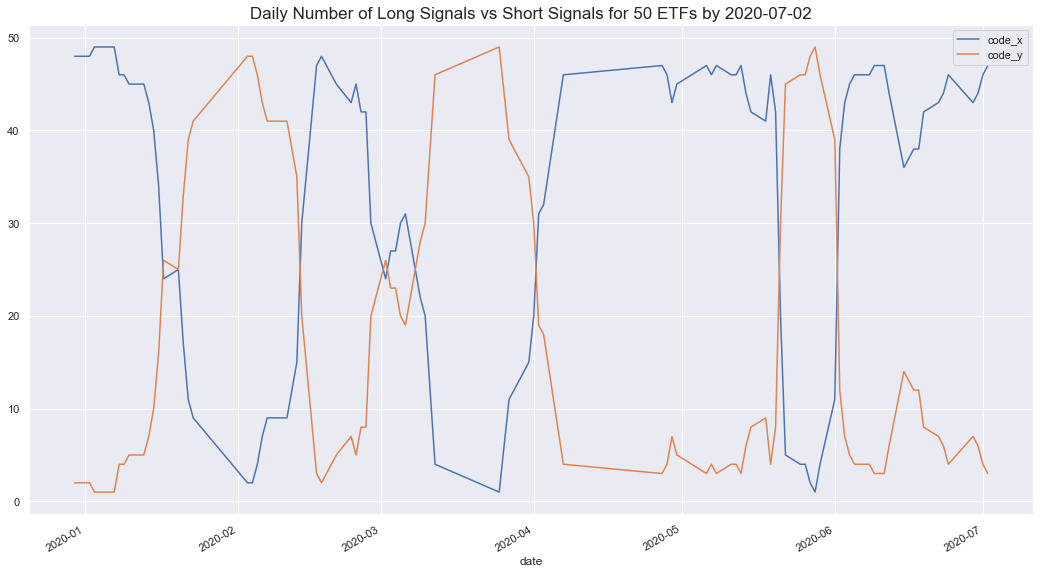

In [444]:
today = macd_long_short_counts[date_col].values[-1]
macd_long_short_counts[['code_x','code_y']].tail(100).plot(figsize = (18,10));
plt.title("Daily Number of Long Signals vs Short Signals for 50 ETFs by {}".format(today), fontsize = 17);

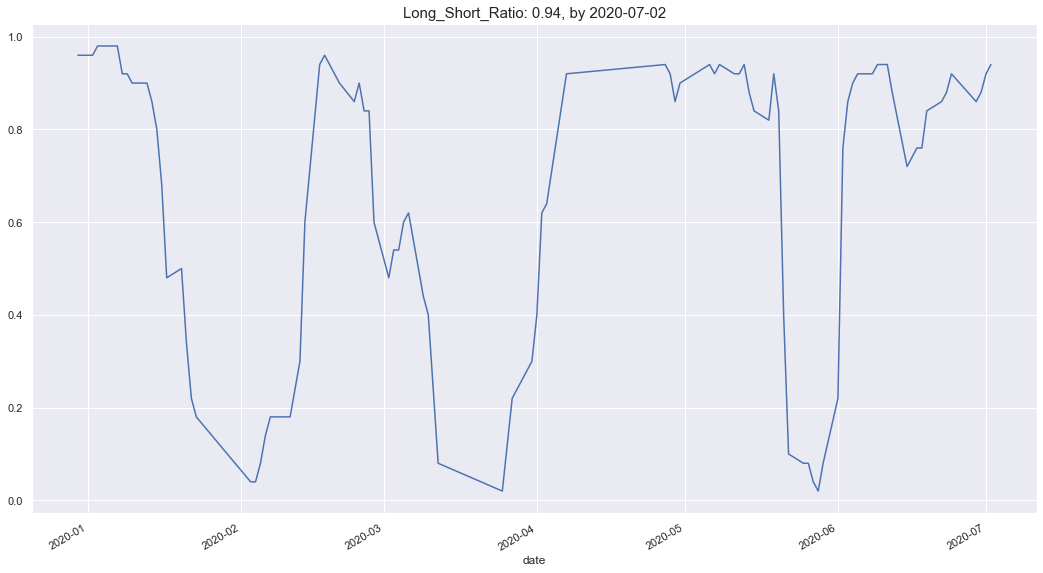

In [445]:
macd_long_short_counts['long_short_ratio'].tail(100).plot(figsize = (18,10))
long_short_ratio = macd_long_short_counts['long_short_ratio'].values[-1]
plt.title("Long_Short_Ratio: {}, by {}".format(round(long_short_ratio,2), today), fontsize =15);

In [446]:
# 在分析环境里，筛选出tickers，然后使用MACD_signals

class BIAS_signals(object):
    
    def __init__(self, stocks_path, tickers, date_col, code_col, price_col, n_fast, n_slow, n_macd, ticker_type):
        self.path = stocks_path
        self.tickers = tickers
        self.date_col = date_col
        self.code_col = code_col
        self.price_col = price_col
        self.ticker_type = ticker_type
    

    def get_mkt_data_df(self):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
        print(self.path)
        csv_path = self.path+"*.csv"
        files = glob.glob(csv_path)
        ticker_df_list = []
        for ticker in self.tickers:
            try:
                ticker_df = pd.read_csv(self.path+ticker+".csv")
                ticker_df = ticker_df.sort_values(self.date_col)
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        try:
            tickers_data_concated = pd.concat(ticker_df_list)
            tickers_data_concated.reset_index(inplace=True)
            del tickers_data_concated['index']  
        except Exception as e:
            print(e)
        return tickers_data_concated
    

    def calc_macd_signals(self):
        tickers_data_concated = get_mkt_data_df(self.path, self.tickers, self.date_col)
        signal_record = []
        signal_data = []
        if len(self.tickers)!=1:
            for ticker in self.tickers:
                try:
                    if self.ticker_type == "float":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==float(ticker)]
                    elif self.ticker_type == "string":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==ticker]
                        
                    signal_df = MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)# 这个地方出错了
                    signal_data.append(signal_df)
                except:
                    pass
            signal_data_df = pd.concat(signal_data)
        else:
            try:                
                signal_df = MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)
            except:
                pass
            signal_data_df = signal_df

        # v1 is the version of generating the og macd signals
        signal_data_df['SIGNAL_DIRECTION'] = signal_data_df['SIGNAL_STATUS'].apply(lambda x: make_numeric_signals(x))
        signal_data_df['SIGNAL_DIRECTION_DIFF'] = signal_data_df.groupby([self.code_col])['SIGNAL_DIRECTION'].diff()
        signal_data_df['SIGNAL_ACTION'] = signal_data_df['SIGNAL_DIRECTION_DIFF'].apply(lambda x: "LONG" if x==2 else("SHORT" if x==-2 else "NO CHANGE"))
        most_recent_signals = signal_data_df.groupby([self.code_col])[[self.date_col,self.code_col,'SIGNAL_STATUS','SIGNAL_ACTION']].tail(1)
        return signal_data_df, most_recent_signals
    